<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Legume Test: BIC of Square Lattice
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>February, 2025</font></center>

***

In [6]:
import numpy as np
import legume
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'


# Define the PhC

In [7]:
n_Si3N4 = 2.02
n_SiO2 = 1.46
a = 336.

d_Si3N4 = 180./a
r = 80./a
eps_c = n_SiO2**2
eps_b = n_Si3N4**2
eps_lower, eps_upper = n_SiO2**2, n_SiO2**2 

In [8]:
lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=d_Si3N4, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
npw = np.shape(gme.gvec)[1]  # number of plane waves in the expansion
print('Number of reciprocal lattice vectors in the expansion: npw = ', npw)

Number of reciprocal lattice vectors in the expansion: npw =  69


In [9]:
# Run the guided-mode expansion
numeig, verbose = 20, True
nk = 20
path = lattice.bz_path(['X', 'G', 'M'], [nk])

gme.run(kpoints=path['kpoints'], gmode_inds=[0, 1, 2, 3], numeig=numeig, verbose=True)
freqs = gme.freqs

nkappa, nfreq = freqs.shape[0], freqs.shape[1]
print(f'Number of wavevectros = {nkappa}, number of frequencies = {nfreq}')

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 1.572    │ │█████████-----------│   47% │
│ Inverse matrix of Fourier-space permittivity              │ 0.034    │ │--------------------│    1% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.991    │ │█████---------------│   29% │
│ Creating GME matrix                                       │ 0.699    │ │████----------------│   21% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 41 k-points   │ 3.363    │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 69 plane waves and 4 guided modes       ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 820 eigenmodes │ 2.938    │
└─────────────────────────────────────────────────────────────────┴──────────┘

Number of wavevectros = 41, number of frequencies = 20


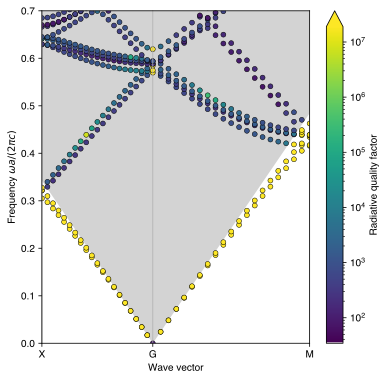

In [10]:
def plot_bands(gme):
    _, ax = plt.subplots(1, figsize = (6, 6))
    legume.viz.bands(gme, Q=True, ax=ax, cone=True, k_units=True, conecolor='lightgray',
                     markersize=5, markeredgecolor='black', markeredgewidth=0.5)
    ax.set_xticks(path['k_indexes'])
    ax.set_xticklabels(path['labels'])
    ax.xaxis.grid('True')
    ax.set_ylim([0., 0.7])

plot_bands(gme)